# Couverture connexe minimum — Algorithme génétique

Ce notebook implémente **l'approche évolutionnaire** décrite dans le rapport :
- population d'individus = grilles de capteurs,
- **initialisation gloutonne** (grille pleine puis suppression aléatoire + test de faisabilité),
- **croisement vertical** avec **bande de superposition**,
- **simplification gloutonne** après croisement (supprime les capteurs inutiles),
- **mutation** = ajouter des capteurs aléatoires puis re-simplifier,
- **durée de vie** (age) pour déclencher des mutations,
- arrêt si la meilleure solution **stagne** pendant `TAU_STAGNATION` générations.


In [1]:
import math
import random
import time
from dataclasses import dataclass
from collections import deque
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


In [2]:
# ----------------------------
# Paramètres (à modifier)
# ----------------------------

N = 20                 # taille de la grille NxN
SINK = (0, 0)          # puits (0,0) comme dans le rapport

RC = 1.0               # rayon de captation (couverture)
RB = 2.0               # rayon de communication (connexité)  (attendu: RB >= RC)

POP_SIZE = 40          # S (taille de population)
MAX_LIFE = 5           # durée de vie max avant mutation (ex: 5 dans le rapport)
TAU_STAGNATION = 30    # arrêt: nb de générations sans amélioration

# Croisement
OVERLAP = None         # largeur "demi-bande" autour de la coupe. None -> auto = ceil(RB)+1

# Mutations
MUT_ADD_FRAC = 0.03    # proportion de cases (hors puits) ajoutées aléatoirement à la mutation

# Budget
MAX_GENERATIONS = 200  # coupe de sécurité (même si pas de stagnation)
NUM_MATINGS_PER_GEN = None  # None -> POP_SIZE (comme leur choix)

SEED = 0


In [3]:
# ----------------------------
# Pré-calculs de voisinages (disques euclidiens sur la grille)
# ----------------------------

def idx(x: int, y: int, n: int) -> int:
    return x * n + y

def xy(i: int, n: int) -> Tuple[int, int]:
    return divmod(i, n)

def offsets_in_radius(r: float) -> List[Tuple[int,int]]:
    R = int(math.floor(r))
    off = []
    r2 = r*r + 1e-12
    for dx in range(-R, R+1):
        for dy in range(-R, R+1):
            if dx*dx + dy*dy <= r2:
                off.append((dx, dy))
    return off

def build_neighbors(n: int, sink_xy: Tuple[int,int], rc: float, rb: float):
    sink_i = idx(sink_xy[0], sink_xy[1], n)
    cov_off = offsets_in_radius(rc)
    com_off = offsets_in_radius(rb)

    # cover_targets[p] = liste des cases (indices) couvertes par un capteur en p (sauf le puits)
    cover_targets = [[] for _ in range(n*n)]
    # comm_neighbors[p] = liste des positions (indices) atteignables par communication RB
    comm_neighbors = [[] for _ in range(n*n)]
    # capteurs qui sont à distance RB du puits
    sink_neighbors = []

    for x in range(n):
        for y in range(n):
            p = idx(x, y, n)
            # couverture
            for dx, dy in cov_off:
                xx, yy = x + dx, y + dy
                if 0 <= xx < n and 0 <= yy < n:
                    t = idx(xx, yy, n)
                    if t != sink_i:
                        cover_targets[p].append(t)

            # communication
            for dx, dy in com_off:
                if dx == 0 and dy == 0:
                    continue
                xx, yy = x + dx, y + dy
                if 0 <= xx < n and 0 <= yy < n:
                    comm_neighbors[p].append(idx(xx, yy, n))

    # voisins du puits
    sx, sy = sink_xy
    for dx, dy in com_off:
        if dx == 0 and dy == 0:
            continue
        xx, yy = sx + dx, sy + dy
        if 0 <= xx < n and 0 <= yy < n:
            p = idx(xx, yy, n)
            if p != sink_i:
                sink_neighbors.append(p)

    return sink_i, cover_targets, comm_neighbors, sink_neighbors

random.seed(SEED)
np.random.seed(SEED)

if RB + 1e-12 < RC:
    raise ValueError("On attend RB >= RC")

SINK_I, COVER_TARGETS, COMM_NEI, SINK_NEI = build_neighbors(N, SINK, RC, RB)

print("Pré-calculs ok:",
      f"|cases|={N*N}, |offsets RC|={len(offsets_in_radius(RC))}, |offsets RB|={len(offsets_in_radius(RB))}")


Pré-calculs ok: |cases|=400, |offsets RC|=5, |offsets RB|=13


In [4]:
# ----------------------------
# Faisabilité + coût (comme dans le rapport: coût = nb capteurs si connexe, sinon N^2)
# ----------------------------

def compute_coverage_counts(sensors: np.ndarray) -> np.ndarray:
    counts = np.zeros(N*N, dtype=np.int16)
    # ajoute la contribution de chaque capteur
    for p in np.where(sensors)[0]:
        for t in COVER_TARGETS[p]:
            counts[t] += 1
    return counts

def connected_to_sink_mask(sensors: np.ndarray) -> np.ndarray:
    vis = np.zeros(N*N, dtype=bool)
    q = deque()

    for p in SINK_NEI:
        if sensors[p] and not vis[p]:
            vis[p] = True
            q.append(p)

    while q:
        u = q.popleft()
        for v in COMM_NEI[u]:
            if sensors[v] and not vis[v]:
                vis[v] = True
                q.append(v)

    return vis

def is_feasible(sensors: np.ndarray, counts: np.ndarray | None = None) -> bool:
    if sensors[SINK_I]:
        return False
    if counts is None:
        counts = compute_coverage_counts(sensors)
    # couverture: toutes les cases sauf le puits doivent être couvertes
    if (counts[np.arange(N*N) != SINK_I] == 0).any():
        return False
    # connexité: tous les capteurs doivent être atteignables depuis le puits
    vis = connected_to_sink_mask(sensors)
    return (vis[sensors].all())

def cost_like_report(sensors: np.ndarray, counts: np.ndarray | None = None) -> int:
    # "jauge" = nb capteurs si connexe, sinon N^2 (pénalité)
    if counts is None:
        counts = compute_coverage_counts(sensors)
    if is_feasible(sensors, counts):
        return int(sensors.sum())
    return N*N


In [5]:
# ----------------------------
# Simplification gloutonne (leur heuristique): tenter de retirer des capteurs au hasard
# ----------------------------

def simplify(sensors: np.ndarray, counts: np.ndarray | None = None, rng: random.Random | None = None):
    if rng is None:
        rng = random.Random()

    sensors = sensors.copy()
    sensors[SINK_I] = False

    if counts is None:
        counts = compute_coverage_counts(sensors)

    # on itère jusqu'à stabilisation (plus aucune suppression possible sur un passage)
    changed = True
    while changed:
        changed = False
        positions = np.where(sensors)[0].tolist()
        rng.shuffle(positions)

        for p in positions:
            # tentative de suppression
            sensors[p] = False
            # mise à jour coverage counts
            for t in COVER_TARGETS[p]:
                counts[t] -= 1

            # test rapide couverture
            if (counts[np.arange(N*N) != SINK_I] == 0).any():
                # rollback
                sensors[p] = True
                for t in COVER_TARGETS[p]:
                    counts[t] += 1
                continue

            # test connexité (BFS) : plus cher, mais ok pour N<=50
            if not is_feasible(sensors, counts):
                sensors[p] = True
                for t in COVER_TARGETS[p]:
                    counts[t] += 1
            else:
                changed = True

    return sensors, counts


In [6]:
# ----------------------------
# Individu + génération initiale (grille pleine -> simplify)
# ----------------------------

@dataclass
class Individual:
    sensors: np.ndarray  # bool (N*N)
    counts: np.ndarray   # int counts couverture (N*N)
    cost: int
    life: int = 0

def full_grid_individual(rng: random.Random) -> Individual:
    sensors = np.ones(N*N, dtype=bool)
    sensors[SINK_I] = False
    counts = compute_coverage_counts(sensors)
    sensors, counts = simplify(sensors, counts, rng=rng)
    c = cost_like_report(sensors, counts)
    return Individual(sensors=sensors, counts=counts, cost=c, life=0)

def init_population(pop_size: int, seed: int) -> List[Individual]:
    pop = []
    for k in range(pop_size):
        rng = random.Random(seed + 1000*k + 17)
        pop.append(full_grid_individual(rng))
    return pop

pop = init_population(POP_SIZE, SEED)
best = min(pop, key=lambda ind: ind.cost)
print("Population initiale:",
      f"meilleur={best.cost} capteurs, moyen={sum(ind.cost for ind in pop)/len(pop):.1f}")


Population initiale: meilleur=131 capteurs, moyen=135.1


In [7]:
# ----------------------------
# Croisement (coupure verticale + bande de superposition) + mutation
# ----------------------------

def crossover(p1: Individual, p2: Individual, rng: random.Random, overlap: int) -> Tuple[Individual, Individual]:
    cut = rng.randrange(0, N)  # colonne de coupure

    # masques colonnes
    cols = np.array([xy(i, N)[1] for i in range(N*N)], dtype=int)
    left = cols < (cut - overlap)
    right = cols > (cut + overlap)
    band = ~(left | right)

    s1 = np.zeros(N*N, dtype=bool)
    s2 = np.zeros(N*N, dtype=bool)

    # enfant 1: gauche père, droite mère, bande = OR
    s1[left] = p1.sensors[left]
    s1[right] = p2.sensors[right]
    s1[band] = p1.sensors[band] | p2.sensors[band]

    # enfant 2: gauche mère, droite père, bande = OR
    s2[left] = p2.sensors[left]
    s2[right] = p1.sensors[right]
    s2[band] = p1.sensors[band] | p2.sensors[band]

    s1[SINK_I] = False
    s2[SINK_I] = False

    # simplification gloutonne (comme dans le rapport: élimine les capteurs inutiles)
    c1_counts = compute_coverage_counts(s1)
    c2_counts = compute_coverage_counts(s2)
    s1, c1_counts = simplify(s1, c1_counts, rng=rng)
    s2, c2_counts = simplify(s2, c2_counts, rng=rng)

    c1 = cost_like_report(s1, c1_counts)
    c2 = cost_like_report(s2, c2_counts)

    return Individual(s1, c1_counts, c1, life=0), Individual(s2, c2_counts, c2, life=0)

def mutate(ind: Individual, rng: random.Random, add_frac: float) -> Individual:
    sensors = ind.sensors.copy()
    sensors[SINK_I] = False

    # ajoute m capteurs aléatoires, puis simplify
    candidates = [i for i in range(N*N) if i != SINK_I]
    m = max(1, int(add_frac * len(candidates)))
    for p in rng.sample(candidates, m):
        sensors[p] = True

    counts = compute_coverage_counts(sensors)
    sensors, counts = simplify(sensors, counts, rng=rng)
    c = cost_like_report(sensors, counts)
    return Individual(sensors, counts, c, life=0)


In [8]:
# ----------------------------
# Boucle génétique (sélection "immédiate" après chaque accouplement, comme décrit)
# ----------------------------

def genetic_search(pop: List[Individual],
                   max_generations: int,
                   tau_stagnation: int,
                   max_life: int,
                   mut_add_frac: float,
                   overlap: int | None,
                   num_matings_per_gen: int | None,
                   seed: int):

    rng = random.Random(seed)

    if overlap is None:
        overlap = int(math.ceil(RB)) + 1  # "bande > RB" (idée du rapport)

    if num_matings_per_gen is None:
        num_matings_per_gen = len(pop)    # choix arbitraire (rapport)

    best = min(pop, key=lambda ind: ind.cost)
    best_cost = best.cost
    stagn = 0

    history_best = [best_cost]
    t0 = time.time()

    for gen in range(1, max_generations + 1):
        # S accouplements "en place" (on remplace directement 2 indices dans la population)
        for _ in range(num_matings_per_gen):
            i, j = rng.sample(range(len(pop)), 2)
            p1, p2 = pop[i], pop[j]

            c1, c2 = crossover(p1, p2, rng=rng, overlap=overlap)

            # règle simple fidèle au texte:
            # - si les enfants sont meilleurs (au sens "global") -> on remplace les parents
            # - sinon on garde les parents et on incrémente leur durée de vie (+ mutation si trop vieux)
            if (c1.cost + c2.cost) < (p1.cost + p2.cost):
                pop[i], pop[j] = c1, c2
            else:
                # parents survivent: vieillissement + mutation éventuelle
                p1.life += 1
                p2.life += 1
                if p1.life > max_life:
                    pop[i] = mutate(p1, rng=rng, add_frac=mut_add_frac)
                if p2.life > max_life:
                    pop[j] = mutate(p2, rng=rng, add_frac=mut_add_frac)

        # update best + stagnation
        cur_best = min(pop, key=lambda ind: ind.cost)
        if cur_best.cost < best_cost:
            best_cost = cur_best.cost
            best = Individual(cur_best.sensors.copy(), cur_best.counts.copy(), cur_best.cost, life=cur_best.life)
            stagn = 0
        else:
            stagn += 1

        history_best.append(best_cost)

        if stagn >= tau_stagnation:
            break

    tsec = time.time() - t0
    return best, history_best, tsec, gen

best_ind, hist, tsec, gens = genetic_search(
    pop=pop,
    max_generations=MAX_GENERATIONS,
    tau_stagnation=TAU_STAGNATION,
    max_life=MAX_LIFE,
    mut_add_frac=MUT_ADD_FRAC,
    overlap=OVERLAP,
    num_matings_per_gen=NUM_MATINGS_PER_GEN,
    seed=SEED
)

print(f"Terminé: générations={gens}, temps={tsec:.2f}s")
print("Meilleure solution:", best_ind.cost, "capteurs")
print("Faisable:", is_feasible(best_ind.sensors, best_ind.counts))


Terminé: générations=62, temps=50.97s
Meilleure solution: 121 capteurs
Faisable: True


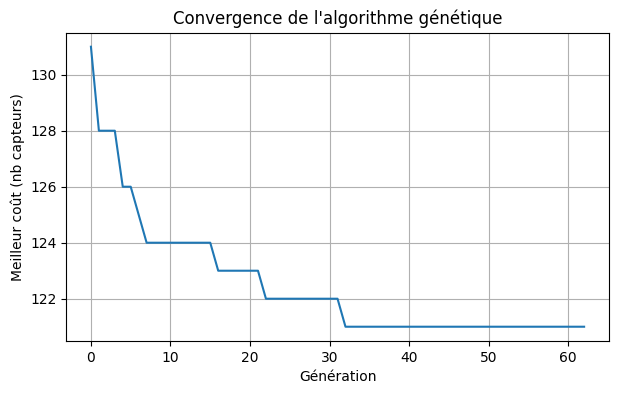

In [9]:
# ----------------------------
# Courbe de convergence (best trouvé)
# ----------------------------

plt.figure(figsize=(7,4))
plt.plot(hist)
plt.xlabel("Génération")
plt.ylabel("Meilleur coût (nb capteurs)")
plt.title("Convergence de l'algorithme génétique")
plt.grid(True)
plt.show()


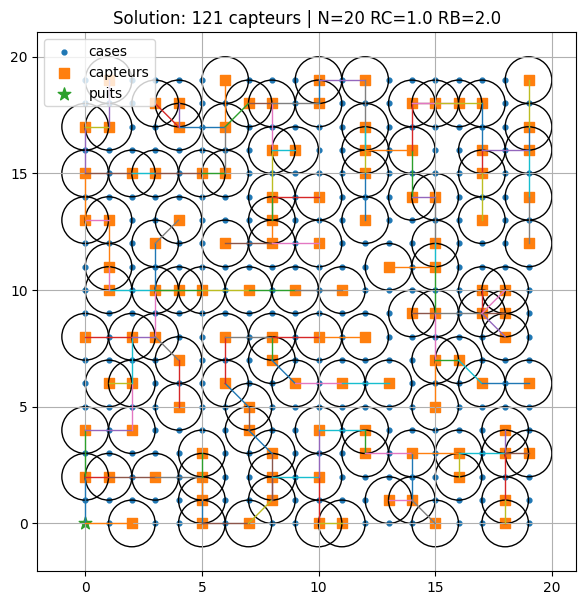

In [10]:
# ----------------------------
# Schéma de la solution (capteurs + arbre de communication + cercles de couverture optionnels)
# ----------------------------

def bfs_tree_edges(sensors: np.ndarray):
    # retourne une liste d'arêtes (a,b) où a == -1 représente le puits
    vis = np.zeros(N*N, dtype=bool)
    q = deque()
    edges = []

    for p in SINK_NEI:
        if sensors[p] and not vis[p]:
            vis[p] = True
            q.append(p)
            edges.append((-1, p))

    while q:
        u = q.popleft()
        for v in COMM_NEI[u]:
            if sensors[v] and not vis[v]:
                vis[v] = True
                q.append(v)
                edges.append((u, v))

    return edges

def plot_solution(ind: Individual, show_coverage: bool = False):
    sensors = ind.sensors
    pts = np.array([xy(i, N) for i in range(N*N)])
    xs, ys = pts[:,0], pts[:,1]

    fig, ax = plt.subplots(figsize=(7,7))

    # toutes les cases à couvrir (hors puits)
    mask_targets = np.ones(N*N, dtype=bool)
    mask_targets[SINK_I] = False
    ax.scatter(xs[mask_targets], ys[mask_targets], s=12, label="cases")

    sel = np.where(sensors)[0]
    ax.scatter(xs[sel], ys[sel], s=55, marker="s", label="capteurs")
    ax.scatter([SINK[0]], [SINK[1]], s=90, marker="*", label="puits")

    # arbre de comm
    for a, b in bfs_tree_edges(sensors):
        if a == -1:
            x1, y1 = SINK
        else:
            x1, y1 = xy(a, N)
        x2, y2 = xy(b, N)
        ax.plot([x1, x2], [y1, y2], linewidth=1)

    # cercles de couverture (à éviter si N grand)
    if show_coverage:
        for p in sel:
            x, y = xy(p, N)
            ax.add_patch(Circle((x, y), RC, fill=False, linewidth=1))

    ax.set_aspect("equal", adjustable="box")
    ax.set_title(f"Solution: {ind.cost} capteurs | N={N} RC={RC} RB={RB}")
    ax.legend()
    ax.grid(True)
    plt.show()

plot_solution(best_ind, show_coverage=(N <= 20))


## Notes pratiques
- Si c'est lent : diminue `N` (ex 20), ou `POP_SIZE`, ou `NUM_MATINGS_PER_GEN`.
- `OVERLAP=None` choisit automatiquement `ceil(RB)+1` (bande épaisse) : ça colle à l'idée “bande > RB”.
- Tu peux comparer avec ton autre approche (ILS) sur les mêmes (N,RC,RB).
